<a href="https://colab.research.google.com/github/daisuke08253649/DeepLearning/blob/main/illustrationidentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import timm
model_list = timm.list_models(pretrained=True)
print(model_list)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [3]:
import os
import torch
import torchvision
import pandas as pd

from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [4]:
train_image_dir = './drive/MyDrive/DeepLearning/illustrationdiscrimination/data/train'
val_image_dir = './drive/MyDrive/DeepLearning/illustrationdiscrimination/data/val'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),

    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir, transform=data_transforms['train'])
val_dataset = torchvision.datasets.ImageFolder(root=val_image_dir, transform=data_transforms['val'])

train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)

print(len(train_dataset))
print(len(val_dataset))

1100
150


In [8]:
def train(model, train_dataloader, criterion, optimizer, train_losses):
    model.train()
    train_loss = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    return train_loss

def val(model, val_dataloader, criterion, val_losses, val_accuracies):
    model.eval()
    val_loss = 0
    val_accuracy = 0

    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).sum().item()

    val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_accuracy / len(val_dataloader.dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    return val_loss, val_accuracy


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch:1, Train_loss:6.390808266587555e-05, Val_loss:0.0009567000670358539, Accuracy:0.9266666666666666
Epoch:2, Train_loss:3.2106731850944925e-06, Val_loss:0.0013507215771824121, Accuracy:0.9133333333333333
Epoch:3, Train_loss:5.907758122702944e-07, Val_loss:0.0026825852692127228, Accuracy:0.9066666666666666
Epoch:4, Train_loss:4.914399482913723e-07, Val_loss:1.3057189789833501e-05, Accuracy:0.94
Epoch:5, Train_loss:3.006308304520644e-07, Val_loss:6.015492544975132e-06, Accuracy:0.96
Epoch:6, Train_loss:3.150814791297307e-07, Val_loss:0.0040276977233588696, Accuracy:0.9333333333333333
Epoch:7, Train_loss:7.40785480957129e-07, Val_loss:0.0019124583341181278, Accuracy:0.9333333333333333
Epoch:8, Train_loss:1.9436583897913806e-07, Val_loss:0.004069243557751179, Accuracy:0.9466666666666667
Epoch:9, Train_loss:1.0574143516350887e-07, Val_loss:3.363088035257533e-05, Accuracy:0.9533333333333334
Epoch:10, Train_loss:1.6958435367087077e-07, Val_loss:4.5797813186254643e-07, Accuracy:0.9533333333

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = timm.create_model('vit_base_patch16_clip_224.openai_ft_in12k_in1k', pretrained=True)
model = model.to(device)

lr = 1e-3
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
val_accuracies = []

cuda


In [ ]:
for i in range(epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, train_losses)
    val_loss, val_accuracy = val(model, val_dataloader, criterion, val_losses, val_accuracies)

    print(f'Epoch: {i+1}, Train_loss: {train_loss}, Val_loss: {val_loss}, Val_accuracy: {val_accuracy}')

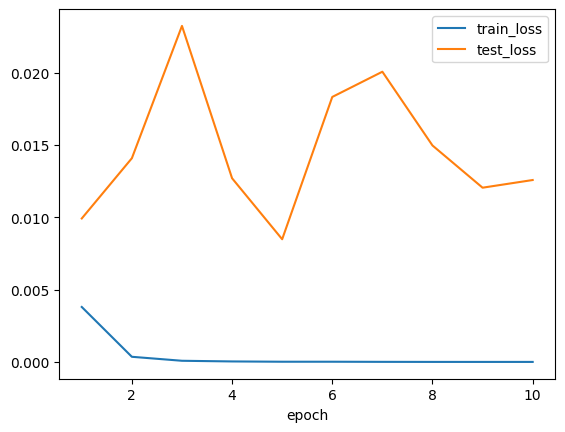

In [9]:
plt.figure()
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label='train_loss')
plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

予測が正解しているデータ:19


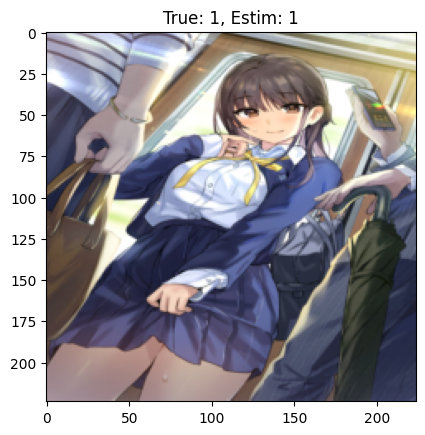

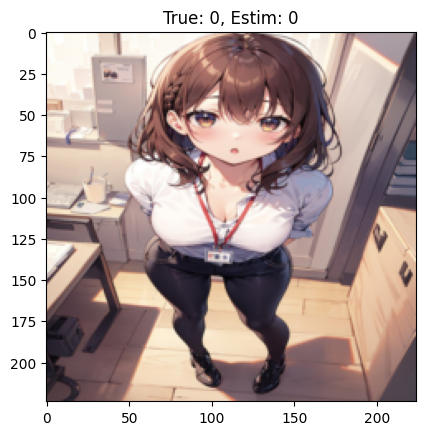

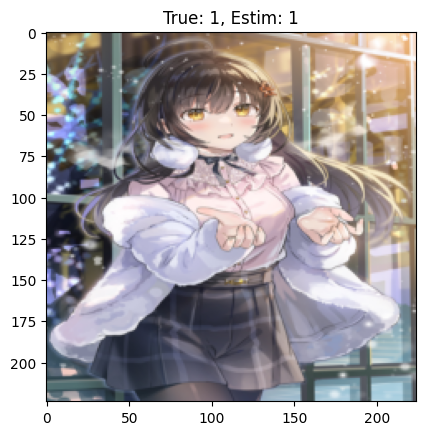

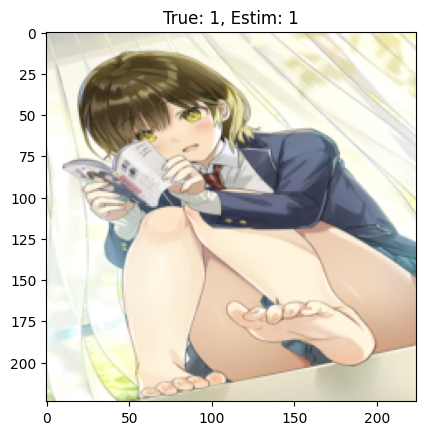

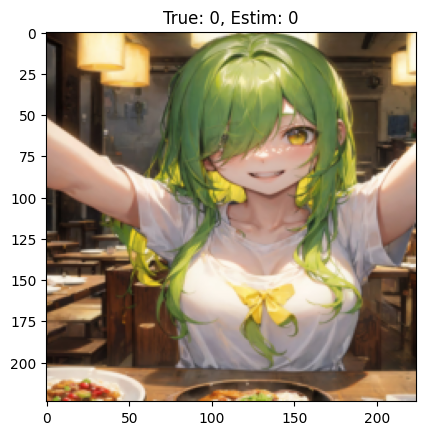

In [10]:
from torch.autograd import Variable

test_iter = iter(test_dataloader)
true_list = []
false_list = []
input, label = next(test_iter)
output = model(Variable(input.cuda()))
_, predict = torch.max(output.data, 1)

for idx in range(len(label)):
    lst = [input[idx], label[idx], predict[idx]]
    if int(label[idx]) == int(predict[idx]):
        true_list.append(lst)
    else:
        false_list.append(lst)

print(f'予測が正解しているデータ:{len(true_list)}')
for idx, tlst in enumerate(true_list[:5]):
    plt.figure(idx+1)
    image = tlst[0].cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    plt.imshow(image, cmap='Blues')
    plt.title('True: {}, Estim: {}'.format(tlst[1], tlst[2]))

予測が不正解のデータ:1


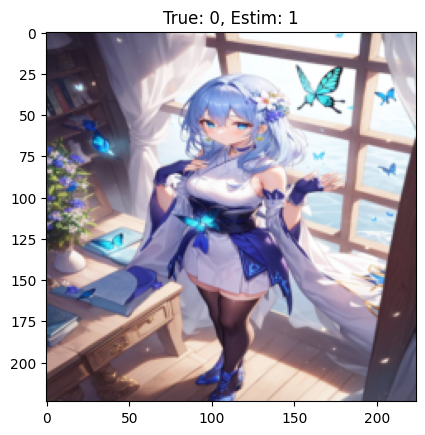

In [11]:
print(f'予測が不正解のデータ:{len(false_list)}')
for idx, flst in enumerate(false_list[:5]):
    plt.figure(idx+1)
    image = flst[0].cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    plt.imshow(image, cmap='Reds')
    plt.title('True: {}, Estim: {}'.format(flst[1], flst[2]))

In [ ]:
#モデル保存
torch.save(model, 'illustrationidentification_model.pth')

In [ ]:
#モデルロード
model = torch.load('./保存されたモデルのパス')
model.eval()